In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchtext
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from time import time
import sys
sys.path.append('../../')

from utils import *

<h1>3-2. ELMo<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-dataset:-IMBD" data-toc-modified-id="Prepare-dataset:-IMBD-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare dataset: IMBD</a></span><ul class="toc-item"><li><span><a href="#For-pretraining" data-toc-modified-id="For-pretraining-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>For pretraining</a></span></li></ul></li><li><span><a href="#Build-the-model" data-toc-modified-id="Build-the-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build the model</a></span><ul class="toc-item"><li><span><a href="#Bidirectional-language-model" data-toc-modified-id="Bidirectional-language-model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Bidirectional language model</a></span></li><li><span><a href="#ELMo" data-toc-modified-id="ELMo-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>ELMo</a></span></li></ul></li><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train the model</a></span><ul class="toc-item"><li><span><a href="#Pretrain-bidirectional-language-model" data-toc-modified-id="Pretrain-bidirectional-language-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Pretrain bidirectional language model</a></span><ul class="toc-item"><li><span><a href="#Intermediate-results" data-toc-modified-id="Intermediate-results-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Intermediate results</a></span></li></ul></li><li><span><a href="#Train-ELMo-for-sentiment-analysis" data-toc-modified-id="Train-ELMo-for-sentiment-analysis-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Train ELMo for sentiment analysis</a></span></li></ul></li></ul></div>

## Prepare dataset: IMBD

In [2]:
from torchtext.experimental.datasets import IMDB
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("spacy")
train, test = IMDB(tokenizer=tokenizer, root="../torchdata/")

/home/psh/.pyenv/versions/3.8.7/lib/python3.8/site-packages/thinc/neural/_custom_kernels.py:36: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/psh/.pyenv/versions/3.8.7/lib/python3.8/site-packages/thinc/neural/_custom_kernels.cu' mode='r' encoding='utf8'>
  SRC = (PWD / "_custom_kernels.cu").open("r", encoding="utf8").read()
/home/psh/.pyenv/versions/3.8.7/lib/python3.8/site-packages/thinc/neural/_custom_kernels.py:39: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/psh/.pyenv/versions/3.8.7/lib/python3.8/site-packages/thinc/neural/_murmur3.cu' mode='r' encoding='utf8'>
  MMH_SRC = (PWD / "_murmur3.cu").open("r", encoding="utf8").read()
100%|██████████| 25000/25000 [00:27<00:00, 922.04lines/s] 


In [3]:
from collections import Counter

vocab = train.get_vocab()

v = Counter(['<s>', '</s>'])
v = torchtext.vocab.Vocab(v, specials=['<s>', '</s>'])
vocab.extend(v)

In [4]:
VOCAB_SIZE = len(vocab)
ngrams = 2

```python
bos = "<s>"
eos = "</s>"

x = []
y = []
for _, words in tqdm(train):
    # Begin-of-sentence token
    x.append([vocab.stoi[bos]] + words[0:ngrams-1].tolist())
    y.append([words[ngrams-1].item(), vocab.stoi[bos]])  # next word, prev word
    
    # in-sentence tokens
    text = words[0:ngrams]
    label = [words[ngrams].item(), vocab.stoi[bos]]
    x.append(text.tolist())
    y.append(label)
    
    for i in range(1, len(words)-ngrams):
        text = words[i:i+ngrams]
        label = [words[i+ngrams].item(), words[i-1].item()]
        x.append(text.tolist())
        y.append(label)
        
    # End-of-sentence token
    x.append(words[i+1:i+ngrams].tolist() + [vocab.stoi[eos]])
    y.append([vocab.stoi[eos], words[i].item()])
```

```python
with open("./IMBD_bigram.json", "w") as w:
    json.dump({"data": x, "label": y}, w)
```

In [5]:
with open("./IMBD_bigram.json") as r:
    xy = json.load(r)

### For pretraining

* transform to character-level n-gram dataset
    * original script
```
%load https://gist.githubusercontent.com/akurniawan/30719686669dced49e7ced720329a616/raw/7b9f9967c01ce87ac505520a5aa58d3b24c55c66/translation_char_example.py
```
    * modified
```
%load https://gist.github.com/naturale0/6bb3b8a5c682bd281de87e408fa71bf1/raw/df8b7e198f149f81c4f72af977760b2eb3226cdf/translation_char_example.py
```

In [6]:
# Modified a little to fit classification
import itertools
from torchtext.experimental.datasets import TextClassificationDataset
from torchtext.vocab import build_vocab_from_iterator
from torchtext.experimental.functional import sequential_transforms

def build_char_vocab(data, index, 
                     bow="<w>", eow="</w>",
                     bos="<s>", eos="</s>"):
    """
    build character level vocabulary
    """
    tok_list = [
        [bow],
        [eow],
        [bos],
        [eos],
    ]
    for line in data:
        tokens = list(itertools.chain.from_iterable(line[index]))
        tok_list.append(tokens)
    return build_vocab_from_iterator(tok_list)


def stoi(vocab):
    """
    change string to index
    """
    def func(tok_iter):
        return [[vocab[char] for char in word]\
                for word in tok_iter]

    return func


def tokenize_char(bow="<w>", eow="</w>", 
                  bos="<s>", eos="</s>",
                  max_word_length=20):
    """
    attach bow, eow token and pad with token
    """
    def func(tok_iter):
        result = np.empty((len(tok_iter), max_word_length+2), dtype=object)
        result[:] = "<pad>"
        
        for i, word in enumerate(tok_iter):
            if "".join(word) == "<s>":
                # Begin-of-sentence token
                result[i, :3] = [bow, bos, eow] #+ ["<pad>"] * (max_word_length - 1)
            elif "".join(word) == "</s>":
                # End-of-sentence token
                result[i, :3] = [bow, eos, eow] #+ ["<pad>"] * (max_word_length - 1)
            else:
                # in-sentence words
                if len(word) < max_word_length:
                    result[i, :len(word)+2] = [bow] + word + [eow]
                else:
                    result[i, :] = [bow] + word[:max_word_length] + [eow]
                
                
#                 result[:len(tok_iter)] = [
#                     [bow] + word + [eow] \
#                     + ["<pad>"] * (max_word_length - len(word)) \
#                     if len(word) < max_word_length \
#                     else [bow] + word[:max_word_length] + [eow]
#                 for word in tok_iter]

        return result

    return func

In [7]:
x = xy["data"][:]
y = xy["label"][:]

In [8]:
# Cache training data for vocabulary construction
train_data = [([vocab.itos[ix] for ix in line[0]], line[1]) for line in tqdm(zip(x, y))]

0it [00:00, ?it/s]

In [9]:
train_data[:3]

[(['<s>', 'I'], [1657, 121411]),
 (['I', 'rented'], [11, 121411]),
 (['rented', 'I'], [14567, 11])]

In [10]:
# Setup vocabularies (both words and chars)
char_vocab = build_char_vocab(train_data, index=0)

6810719lines [00:06, 990343.58lines/s] 


In [11]:
# Building the dataset with character level tokenization
def char_tokenizer(words):
    return [list(word) for word in words]

char_transform = sequential_transforms(
    char_tokenizer, 
    tokenize_char(), 
    stoi(char_vocab),
    lambda x: torch.tensor(x)
)

trainset = TextClassificationDataset(
    train_data,
    char_vocab,
    (char_transform, lambda x: torch.tensor(x)),
)

In [12]:
print([[char_vocab.itos[i] for i in w] for w in trainset[17][0]] [1][:13])

['<w>', 's', 'u', 'r', 'r', 'o', 'u', 'n', 'd', 'e', 'd', '</w>', '<pad>']


In [13]:
# Prepare DataLoader
# def collate_fn(batch):
#     text, label = zip(*batch)
#     label = torch.LongTensor(label)
#     text = torch.stack(text)
#     #lens = list(map(lambda x: len(x[(x != 0).all(dim=1)]), text))
    
#     return text, label

pretrainloader = data.DataLoader(trainset, 
                                 batch_size=256,
                                 num_workers=4)

In [14]:
xx, yy = next(iter(pretrainloader))
xx.shape, yy.shape

(torch.Size([256, 2, 22]), torch.Size([256, 2]))

## Build the model

### Bidirectional language model

In [15]:
class CharConv(nn.Module):
    
    def __init__(self):
        super(CharConv, self).__init__()
        
        # Embedding layer
        CHAR_EMBEDDING_DIM = 16
        self.char_embedding = nn.Embedding(len(char_vocab), CHAR_EMBEDDING_DIM)
        
        # Conv layers
        self.conv1 = nn.Conv2d(CHAR_EMBEDDING_DIM, 2, 1)
        self.conv2 = nn.Conv2d(CHAR_EMBEDDING_DIM, 2, (1, 2))
        self.conv3 = nn.Conv2d(CHAR_EMBEDDING_DIM, 4, (1, 3))
        self.conv4 = nn.Conv2d(CHAR_EMBEDDING_DIM, 8, (1, 4))
        self.conv5 = nn.Conv2d(CHAR_EMBEDDING_DIM, 16, (1, 5))
        self.conv6 = nn.Conv2d(CHAR_EMBEDDING_DIM, 32, (1, 6))
        self.conv7 = nn.Conv2d(CHAR_EMBEDDING_DIM, 64, (1, 7))
        self.convs = [
            self.conv1, self.conv2, self.conv3,
            self.conv4, self.conv5, self.conv6, self.conv7,
        ]
        
    
    def forward(self, x):
        # character-level convolution
        x = self.char_embedding(x).permute(0,3,1,2)
        x = [conv(x) for conv in self.convs]
        x = [F.max_pool2d(x_c, kernel_size=(1, x_c.shape[3])) for x_c in x]
        x = [torch.squeeze(x_p, dim=3) for x_p in x]
        x = torch.hstack(x)  # 1, n_batch, concat_length
        #x = x.view(2, 0, 1)
        
        return x

In [16]:
class BiLSTM(nn.Module):
    def __init__(self):
        super(BiLSTM, self).__init__()
        # Bi-LSTM
        self.lstm_f1 = nn.LSTM(128, 128)
        self.lstm_r1 = nn.LSTM(128, 128)
        self.dropout = nn.Dropout(0.1)
        self.proj = nn.Linear(128, 64, bias=False)
        self.lstm_f2 = nn.LSTM(64, 128)
        self.lstm_r2 = nn.LSTM(64, 128)
    
    def forward(self, x):
        ## input shape:
        # seq_len, batch_size, 128
        
        # 1st LSTM layer
        x_f = x
        x_r = x.flip(dims=[0])
        ## forward feed
        o_f1, (h_f1, __) = self.lstm_f1(x_f)
        o_f1 = self.dropout(o_f1)
        ## backward feed
        o_r1, (h_r1, __) = self.lstm_r1(x_r)
        o_r1 = self.dropout(o_r1)
        h1 = torch.stack((h_f1, h_r1)).squeeze(dim=1)
        
        # main + skip connection
        x2_f = self.proj(o_f1 + x_f)
        x2_r = self.proj(o_r1 + x_r)
        
        # 2nd LSTM layer
        _, (h_f2, __) = self.lstm_f2(x2_f)
        _, (h_r2, __) = self.lstm_r2(x2_r)
        h2 = torch.stack((h_f2, h_r2)).squeeze(dim=1)
        
        return h1, h2

In [17]:
class BiLangModel(nn.Module):
    """
    Bidirectional language model (will be pretrained)
    """
    def __init__(self, char_cnn, bi_lstm):
        super(BiLangModel, self).__init__()
        
        # Highway connection
        CHAR_EMBEDDING_DIM = 16
        self.highway = nn.Linear(128, 128)
        self.transform = nn.Linear(128, 128)
        self.char_cnn = char_cnn
        self.bi_lstm = bi_lstm
        
    def forward(self, x):
        # Character-level convolution
        x = self.char_cnn(x)
        x = x.permute(2, 0, 1)
        
        # highway
        h = self.highway(x)
        t_gate = torch.sigmoid(self.transform(x))
        c_gate = 1 - t_gate
        x_ = h * t_gate + x * c_gate
        
        # Bi-LSTM
        x1, x2 = self.bi_lstm(x_)
        
        return x, x1, x2

In [18]:
class Pretrainer(nn.Module):
    def __init__(self, bilm, ngrams):
        super(Pretrainer, self).__init__()
        
        # last layer: classifier
        self.fc = nn.Linear(128, 1024)
        self.bilm = bilm
        
    def forward(self, x):
        _, __, x = self.bilm(x)
        
        # fully-connected layer (classify)
        x = x.permute(1, 0, 2)
        x = self.fc(x)
        
        return x

In [19]:
charconv = CharConv()
bilstm = BiLSTM()
bilm = BiLangModel(charconv, bilstm)
model = Pretrainer(bilm, ngrams)

bilm(xx)[0].shape, bilm(xx)[1].shape, bilm(xx)[2].shape, model(xx).shape

(torch.Size([2, 256, 128]),
 torch.Size([2, 256, 128]),
 torch.Size([2, 256, 128]),
 torch.Size([256, 2, 1024]))

```python
from torchviz import make_dot

charconv = CharConv()
bilstm = BiLSTM()
bilm = BiLangModel(charconv, bilstm)

model = Pretrainer(bilm, ngrams)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.AdaptiveLogSoftmaxWithLoss(1024, VOCAB_SIZE, cutoffs=[10, 100, 1000, 10000])

output = model(xx).view(-1, 1024)
target = yy.flatten()

make_dot(criterion(output, target).loss).render("BiLanguageModel", format="png")
```

![](BiLanguageModel.png)

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.61E-02


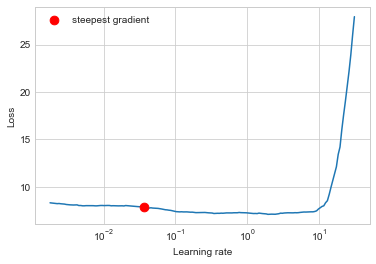

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.036123426997094324)

In [164]:
from torch_lr_finder import LRFinder

charconv = CharConv(); bilstm = BiLSTM()
bilm = BiLangModel(charconv, bilstm)

model = Pretrainer(bilm, ngrams)

optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
criterion_ = nn.AdaptiveLogSoftmaxWithLoss(
    1024, VOCAB_SIZE, cutoffs=[10, 100, 1000, 10000]
)
criterion = lambda x, y: criterion_(x.view(-1, 1024), y.flatten()).loss

lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(pretrainloader, start_lr=1e-3, end_lr=100, num_iter=200)
lr_finder.plot(log_lr=True)

### ELMo

## Train the model

### Pretrain bidirectional language model

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [22]:
# initialize model
charconv = CharConv()
bilstm = BiLSTM()
bilm = BiLangModel(charconv, bilstm)

model = Pretrainer(bilm, ngrams).to(device)

In [ ]:
# ===== load pretrained model here, then proceed ===== #

In [32]:
model.to(device)
model.train()

Pretrainer(
  (fc): Linear(in_features=128, out_features=1024, bias=True)
  (bilm): BiLangModel(
    (highway): Linear(in_features=128, out_features=128, bias=True)
    (transform): Linear(in_features=128, out_features=128, bias=True)
    (char_cnn): CharConv(
      (char_embedding): Embedding(182, 16)
      (conv1): Conv2d(16, 2, kernel_size=(1, 1), stride=(1, 1))
      (conv2): Conv2d(16, 2, kernel_size=(1, 2), stride=(1, 1))
      (conv3): Conv2d(16, 4, kernel_size=(1, 3), stride=(1, 1))
      (conv4): Conv2d(16, 8, kernel_size=(1, 4), stride=(1, 1))
      (conv5): Conv2d(16, 16, kernel_size=(1, 5), stride=(1, 1))
      (conv6): Conv2d(16, 32, kernel_size=(1, 6), stride=(1, 1))
      (conv7): Conv2d(16, 64, kernel_size=(1, 7), stride=(1, 1))
    )
    (bi_lstm): BiLSTM(
      (lstm_f1): LSTM(128, 128)
      (lstm_r1): LSTM(128, 128)
      (dropout): Dropout(p=0.1, inplace=False)
      (proj): Linear(in_features=128, out_features=64, bias=False)
      (lstm_f2): LSTM(64, 128)
      (

In [33]:
LR = 0.05
N_EPOCH = 100
MAX_LR = 0.1

optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
criterion = nn.AdaptiveLogSoftmaxWithLoss(
    1024, VOCAB_SIZE, cutoffs=[10, 100, 1000, 10000]
).to(device)

# init scheduler
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=MAX_LR,  # from LR range test plot
    epochs=N_EPOCH, 
    steps_per_epoch=len(pretrainloader)
)

In [34]:
def accuracy(output, y):
    with torch.no_grad():
        pred = criterion.log_prob(output).argmax(dim=1)
    correct = (pred == y).float()
    #print(pred.shape, correct.shape)
    return correct.sum() / len(correct)

In [35]:
def train(model, dataloader, criterion, optimizer):
    loss_epoch = 0.
    acc_epoch = 0.
    for x, y in dataloader:
        model.zero_grad()
        
        x = x.to(device)
        y = y.flatten().to(device)
        
        out = model(x).view(-1, 1024)
        loss = criterion(out, y).loss
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        loss_epoch += loss.item()
        acc_epoch += accuracy(out, y).item()
        
    return loss_epoch, acc_epoch

In [28]:
losses = []
accs = []

In [36]:
for i in range(1, N_EPOCH+1):
    t0 = time()
    
    loss_epoch, acc_epoch = train(model, pretrainloader, criterion, optimizer)
    losses.append(loss_epoch)
    accs.append(acc_epoch)
    
    t1 = time()
    
    if i % 1 == 0:
        print(f"epoch: {i:03}, loss: {loss_epoch/len(pretrainloader): .3f}, acc: {acc_epoch/len(pretrainloader): .4f},  lr: {scheduler.get_last_lr()[0]: .3f}, {(t1-t0)/60: .1f} min")

epoch: 001, loss:  6.761, acc:  0.1264,  lr:  0.004,  13.0 min
epoch: 002, loss:  6.553, acc:  0.1451,  lr:  0.005,  13.1 min
epoch: 003, loss:  6.467, acc:  0.1515,  lr:  0.006,  13.0 min
epoch: 004, loss:  6.411, acc:  0.1561,  lr:  0.008,  13.1 min
epoch: 005, loss:  6.370, acc:  0.1592,  lr:  0.010,  13.0 min
epoch: 006, loss:  6.339, acc:  0.1618,  lr:  0.013,  13.0 min
epoch: 007, loss:  6.313, acc:  0.1641,  lr:  0.016,  13.0 min
epoch: 008, loss:  6.293, acc:  0.1656,  lr:  0.020,  13.0 min
epoch: 009, loss:  6.276, acc:  0.1670,  lr:  0.024,  13.0 min
epoch: 010, loss:  6.262, acc:  0.1680,  lr:  0.028,  13.0 min
epoch: 011, loss:  6.250, acc:  0.1690,  lr:  0.032,  12.9 min
epoch: 012, loss:  6.241, acc:  0.1698,  lr:  0.037,  13.0 min
epoch: 013, loss:  6.232, acc:  0.1705,  lr:  0.042,  13.0 min
epoch: 014, loss:  6.225, acc:  0.1711,  lr:  0.047,  13.0 min
epoch: 015, loss:  6.218, acc:  0.1716,  lr:  0.052,  13.0 min
epoch: 016, loss:  6.213, acc:  0.1721,  lr:  0.057,  1

In [37]:
torch.save({'model_state_dict': model.state_dict(),
            'loss': losses,
            'acc': accs},
           f"./ELMo-BiLM_SGD_lr{LR}-{MAX_LR}._momentum0.9_epoch{N_EPOCH}+100.pth")

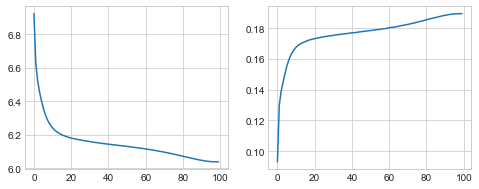

In [29]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(np.array(losses) / len(pretrainloader))
plt.subplot(122)
plt.plot(np.array(accs) / len(pretrainloader))

#### Intermediate results

In [31]:
charconv = CharConv()
bilstm = BiLSTM()
bilm = BiLangModel(charconv, bilstm)
model = Pretrainer(bilm, ngrams)

checkpoint = torch.load("./ELMo-BiLM_SGD_lr0.05-0.1._momentum0.9_epoch100.pth",
                        map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["model_state_dict"])
losses = checkpoint["loss"]
accs = checkpoint["acc"]

In [41]:
model.to(torch.device("cpu"))
model.eval();  # evaluation mode

In [42]:
N_WORDS = 150
words = list(zip(*vocab.freqs.most_common(N_WORDS)))[0]
words_input = stoi(char_vocab)(tokenize_char()(char_tokenizer(words)))
words_input = torch.tensor(words_input).view(N_WORDS, 1, -1)

In [74]:
def embedding(words_idx):
    if isinstance(words_idx, int):
        words_idx = [words_idx]
    
    words = [vocab.itos[i] for i in words_idx]
    
    words_input = stoi(char_vocab)(tokenize_char()(char_tokenizer(words)))
    words_input = torch.tensor(words_input).view(len(words), 1, -1)
    
    with torch.no_grad():
        out = model.bilm(words_input)
        x1 = torch.vstack(out).mean(dim=0)
    return x1.detach().T

torch.Size([150, 1, 22])
torch.Size([1, 150, 128]) torch.Size([2, 150, 128]) torch.Size([2, 150, 128])
torch.Size([150, 128])


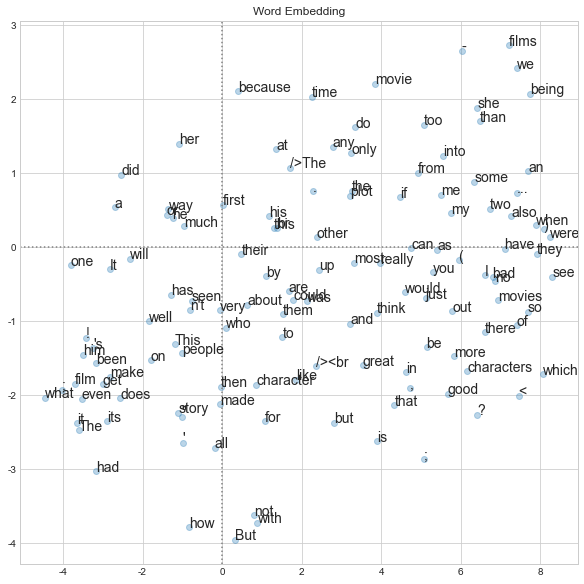

In [71]:
plot_embedding(vocab.freqs, embedding, vocab.stoi);

In [75]:
for word in ["angel", "snow", "love", "death"]:
    print(find_similar(word, vocab.freqs, embedding, vocab.stoi))

['drivel', 'anger', 'uncle', 'father', 'legend']
['slow', 'row', 'new', 'horrid', 'sport']
['quote', 'loved', 'live', 'forgive', 'move']
['breath', 'depth', 'birth', 'mouth', 'deaths']


### Train ELMo for sentiment analysis